# Отправка запроса в Тритон

In [1]:
!python /app/src/client.py --image /app/dataset/test_imgs/horses.jpg --num-reqs 100

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]
Среднее время обработки запроса: 0.15644750595092774 s


In [2]:
import tritonclient.http as httpclient
from PIL import Image
import numpy as np
import cv2
import bbox_visualizer as bbv
import matplotlib.pyplot as plt


def infer(image_file, model_name = 'infer_pipeline'):
    with open(image_file, 'rb') as fi:
        image_bytes = fi.read()
    image_bytes = np.array([image_bytes], dtype=np.bytes_)
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('IMAGE_BYTES', image_bytes.shape, "BYTES"))
    inputs[0].set_data_from_numpy(image_bytes)
    # Define model's outputs
    outputs = []
    outputs.append(httpclient.InferRequestedOutput('BBOXES'))
    outputs.append(httpclient.InferRequestedOutput('CLASSES'))
    outputs.append(httpclient.InferRequestedOutput('SCORES'))
    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="triton:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)
    return outputs


def draw_outputs_on_image(image_path, outputs, threshold):
    threshold_outputs = {'bboxes':[], 'classes': [], 'scores':[]}
    for bbox, category, score in zip(outputs['BBOXES'], outputs['CLASSES'], outputs['SCORES']):
        if score > 0.8:
            threshold_outputs['bboxes'].append(bbox)
            threshold_outputs['classes'].append(category)
            threshold_outputs['scores'].append(score)

    # Reading an image in default mode
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes = [list(map(int, i)) for i in threshold_outputs['bboxes']]
    image_1 = bbv.draw_multiple_rectangles(image, bboxes)
    classes = [f"{label.decode('utf-8')} {round(score, 1)}" for label, score in zip(threshold_outputs['classes'], threshold_outputs['scores'])]
    image_2 = bbv.add_multiple_labels(image_1, classes, bboxes)
    plt.figure(figsize=(10,10)); plt.imshow(image_2) 


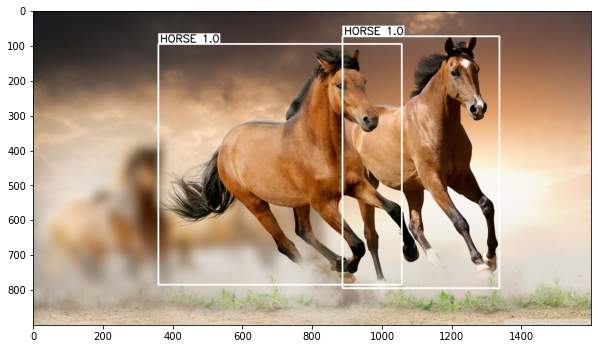

In [3]:
image_file = '/app/dataset/test_imgs/horses.jpg'
result = infer(image_file)
draw_outputs_on_image(image_file, result, 0.9)